# Compare data from Collection 3 to Collection 2 Fractional Cover

* First display data at test sites
* Retrieve cloud-masked Collection 3 NBART to use as cloud masking and image comparison
* Then retrieve C3 Fractional Cover data
* Then retrieve C2 data to match 

To do: 
* Daskify, because things are large
* Deal with clouds, and/or try and select matching scenes - we're going to have to use collection3 fmask to mask collection 2 fractional cover, as no collection 2 available on the sandbox
* Plot against each other and against NBART
* Plot heat map of differences
* Regress the two against each other to see the differences?
* Water mask out with WOfS

In [1]:
%matplotlib inline

from copy import deepcopy
import cartopy
import datetime
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import xarray as xr

#modules for datacube
import datacube
from datacube.utils import masking
from datacube.helpers import ga_pq_fuser

# Import external functions from dea-notebooks
sys.path.append('../Scripts/')
sys.path.append('../Development_notebooks_BD/10_Scripts/')
import dea_plotting, dea_datahandling
import DEADataHandling #try and use old function to load, mask and concatenate C2 fractional cover

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

from odc.ui import with_ui_cbk

%load_ext autoreload
%autoreload 1

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-FC')

## Take a look at our dataset density

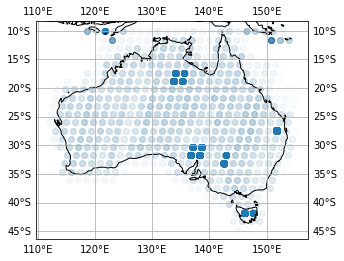

In [3]:
records = dc.find_datasets(product='ga_ls_fc_3')
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.scatter(*zip(*[(i.extent.centroid.to_crs('epsg:4326').points)[0] for i in records]), alpha =0.02)
ax.coastlines()
g = ax.gridlines(draw_labels=True); g.top_labels = g.right_labels = True
None #feed a null to jupyter environment so it doesn't print an output above our graph

define our query area + time

In [32]:
query = {'output_crs':'epsg:3577',
         'resolution':(-30,30),
         'group_by':'solar_day',
         'region_code':"090079",
         'lat':(-27.31, -27.41),
         'lon':(151.01, 151.12),
         'time':('2018-05-01', '2018-06-01'),
         'group_by' : 'solar_day'}

Check out how much data we have

In [33]:
#count the number of datasets for fc3
datasets_fc3 = dc.find_datasets(product='ga_ls_fc_3', **query)
len(datasets_fc3)

4

Load collection 3 fractional cover

In [34]:
ds_fc3 = dc.load(product='ga_ls_fc_3', **query, progress_cbk=with_ui_cbk())
print(ds_fc3)

<xarray.Dataset>
Dimensions:      (time: 4, x: 411, y: 424)
Coordinates:
  * time         (time) datetime64[ns] 2018-05-02T23:47:27.091831 ... 2018-05...
  * y            (y) float64 -3.1e+06 -3.1e+06 ... -3.112e+06 -3.112e+06
  * x            (x) float64 1.85e+06 1.85e+06 1.85e+06 ... 1.862e+06 1.862e+06
    spatial_ref  int32 3577
Data variables:
    bs           (time, y, x) uint8 3 5 16 6 6 5 5 9 ... 26 36 37 44 43 8 10 27
    pv           (time, y, x) uint8 54 52 45 50 53 52 46 ... 18 9 17 25 11 8 14
    npv          (time, y, x) uint8 41 42 37 42 39 42 47 ... 53 38 32 80 81 57
    ue           (time, y, x) uint8 16 13 13 14 16 15 13 13 ... 10 9 8 8 9 6 7 7
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref


Load collection 2 fractional cover for each satellite separately

for collection 2 query, remove the 'region' setting from the dictionary as it doesn't exist in collection 3. This is useful to find the datasets for collection 2.

In [40]:
query_c2 = deepcopy(query) #copy original query to second dictionary
query_c2.pop('region_code', None) #remove region code from c2 query
None #don't print results

In [41]:
#count the number of datasets for fc2 ls5
datasets_ls5_fc2 = dc.find_datasets(product='ls5_fc_albers', **query_c2)
#count the number of datasets for fc2 ls7
datasets_ls7_fc2 = dc.find_datasets(product='ls7_fc_albers', **query_c2)
#count the number of datasets for fc2 ls8
datasets_ls8_fc2 = dc.find_datasets(product='ls8_fc_albers', **query_c2)

Load and concatenate fractional cover for collection 2 data

In [42]:
if datasets_ls5_fc2:
    print(f'loading {len(datasets_ls5_fc2)} ls5 fc c2')
    ds_fc2_5 = dc.load(product = 'ls5_fc_albers', like = ds_fc3, progress_cbk=with_ui_cbk())
else:
    print('no ls5 fc c2')
    ds_fc2_5= None
    
if datasets_ls7_fc2:    
    print(f'loading {len(datasets_ls7_fc2)} ls7 fc c2')
    ds_fc2_7 = dc.load(product = 'ls7_fc_albers', like = ds_fc3, progress_cbk=with_ui_cbk())
else:
    print('no ls7 fc c2')
    ds_fc2_7= None
    
if datasets_ls8_fc2:  
    print(f'loading {len(datasets_ls8_fc2)} ls8 fc c2')
    ds_fc2_8 = dc.load(product = 'ls8_fc_albers', like = ds_fc3, progress_cbk=with_ui_cbk())
else:
    print('no ls8 fc c2')
    ds_fc2_8= None
    
#combine satellite data for the three landsats into one fractional cover dataset
ds_list = []
for i in [ds_fc2_5, ds_fc2_7, ds_fc2_8]:
    if i:
        ds_list.append(i)

#concatenate fractional cover for ls 5, 7, 8 into one dataset
ds_fc2 = xr.concat(ds_list, dim='time')

no ls5 fc c2
loading 4 ls7 fc c2


loading 8 ls8 fc c2


In [43]:
# Remove milliseconds to make data comparable
ds_fc2['time'] = ds_fc2.indexes['time'].normalize()
ds_fc3['time'] = ds_fc3.indexes['time'].normalize()

## Filter fractional cover scenes using WOfS feature layers (WOFLs) 
- Use the wofs dataset to create scene-by-scene masks to remove areas of water
- For more information on WOfS, see the [DEA WOfS and Water Classifier Notebook](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/Image_classification/DEA_WOfS_and_water_classifier.ipynb)
- There may be errors in the WOfS tiles until WOfS is finished 

In [44]:
# Choose matching timesteps to compare
ds_compare = ds_fc3["time"].isin(ds_fc2["time"].values)
ds_fc3_sel = ds_fc3.sel(time=ds_compare)
ds_fc2_sel = ds_fc2.where(ds_fc2.time == ds_fc3.time)

In [45]:
#free up memory 
del ds_fc2_5, ds_fc2_7, ds_fc2_8, ds_fc2, ds_fc3, ds_compare  

### Mask out nodata values by setting NaN = 255

In [46]:
ds_fc2_sel = ds_fc2_sel.where(ds_fc2_sel!=255)
ds_fc3_sel = ds_fc3_sel.where(ds_fc3_sel!=255)

In [50]:
ds_fc3_sel

<xarray.Dataset>
Dimensions:      (time: 3, x: 411, y: 424)
Coordinates:
  * time         (time) datetime64[ns] 2018-05-02 2018-05-10 2018-05-18
  * y            (y) float64 -3.1e+06 -3.1e+06 ... -3.112e+06 -3.112e+06
  * x            (x) float64 1.85e+06 1.85e+06 1.85e+06 ... 1.862e+06 1.862e+06
    spatial_ref  int32 3577
Data variables:
    bs           (time, y, x) float64 3.0 5.0 16.0 6.0 6.0 ... 32.0 0.0 0.0 28.0
    pv           (time, y, x) float64 54.0 52.0 45.0 50.0 ... 41.0 9.0 nan 8.0
    npv          (time, y, x) float64 41.0 42.0 37.0 42.0 ... 90.0 97.0 63.0
    ue           (time, y, x) float64 16.0 13.0 13.0 14.0 ... 11.0 4.0 6.0 6.0
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref

### Plot Fractional Cover and Unmixing Error Bands
Note that Unmixing Error is high over water

In [53]:
#just a scene we want to plot - this can be done other ways
scene = 2

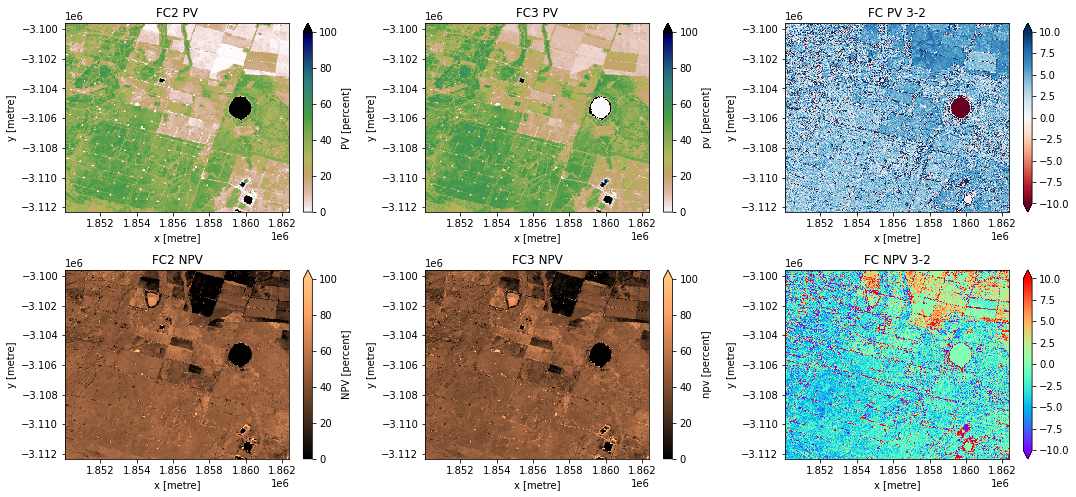

In [68]:
ds = ds_fc3_sel

#set up our images on a grid using gridspec
plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(3,4) # set up a 2 x 2 grid of 4 images for better presentation

#plot Collection 2 Photosynthetic Veg
ax1=plt.subplot(gs[0,0])
ds_fc2_sel.PV.isel(time=scene).plot(cmap='gist_earth_r', vmin=0, vmax=100)
ax1.set_title('FC2 PV')

#Plot Collection 3 Photosynthetic Veg
ax1=plt.subplot(gs[0,1])
ds_fc3_sel.pv.isel(time=scene).plot(cmap='gist_earth_r',vmin=0, vmax=100)
ax1.set_title('FC3 PV')

#Plot the delta
ax1=plt.subplot(gs[0,2])
(ds_fc3_sel.pv.isel(time=scene) - ds_fc2_sel.PV.isel(time=scene)).plot(cmap='RdBu', vmin=-10, vmax =10)

ax1.set_title('FC PV 3-2')

#plot Collection 2  Non-Photosynthetic Veg
ax3=plt.subplot(gs[1,0])
ds_fc2_sel.NPV.isel(time=scene).plot(cmap='copper',vmin=0, vmax=100)
ax3.set_title('FC2 NPV')

#plot Collection 3  Non-Photosynthetic Veg
ax3=plt.subplot(gs[1,1])
ds_fc3_sel.npv.isel(time=scene).plot(cmap='copper',vmin=0, vmax=100)
ax3.set_title('FC3 NPV')

#Plot the delta  Non-Photosynthetic Veg
ax3=plt.subplot(gs[1,2])
(ds_fc3_sel.npv.isel(time=scene) - ds_fc2_sel.NPV.isel(time=scene)).plot(cmap='rainbow', vmin=-10, vmax =10)
ax3.set_title('FC NPV 3-2')

# ax2=plt.subplot(gs[1,0])
# ds.bs.isel(time=scene).plot(cmap='Oranges')
# ax2.set_title('BS')



# ax4=plt.subplot(gs[1,1])
# ds.ue.isel(time=scene).plot(cmap='magma')
# ax4.set_title('UE')

plt.tight_layout()
plt.show()

### We could filter using the unmixing error, but using WOfS is more robust.

### load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'

In [ ]:
#load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'
wofls = dc.load(product = 'ga_ls_wofs_3 ', like=ds)

### Two ways of displaying what the values in the wofs data mean:
WOfS uses [bit flags](http://datacube-core.readthedocs.io/en/latest/dev/api/masking.html) to flag pixels as 'wet' or otherwise

In [ ]:
masking.describe_variable_flags(wofls, with_pandas=True)

In [ ]:
for key in wofls.water.flags_definition.keys():
    print('{}  {}'.format(key, wofls.water.flags_definition[key]))

### Here is what the WOFL mask looks like on one timestep:

In [ ]:
wetwofl = masking.make_mask(wofls, wet=True)
wetwofl.water.isel(time=0).plot()
#drywofl = masking.make_mask(wofls, dry=True)
#drywofl.water.isel(time=0).plot()

In [ ]:
#match WOFL times to our fractional cover times
unwofld = ds.where(ds.time == wetwofl.time)
#mask out water from fractional cover
unwofld = unwofld.where(wetwofl.water==False)

### Here is what Fractional Cover looks like with WOFL removed:

In [ ]:
unwofld.PV.isel(time=0).plot()

### Edit save file path to choose where to save your output files

In [ ]:
#save files to your home directory (add your outpath here if you want to change it)
savefilepath = os.path.expanduser('~/')

## Save Fractional Cover scenes to NetCDF


In [ ]:
try:
    DEADataHandling.write_your_netcdf(unwofld, 'FC25', savefilepath+'FC25'+'.nc', crs = ds.crs)
#complain if the file already exists but don't fail    
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))
print('wrote to netCDF' )

## Save Fractional Cover scenes to GeoTIFF


In [ ]:
ds = unwofld
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    #drop the time dimension for only one timestep
    #write the dataset without the data percentage to file
    ds1 = ds.squeeze()
    ds1 = ds1.drop('data_perc')
    write_geotiff(savefilepath+'FC25_'+'.tif', ds1)

elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        try:
            write_geotiff(savefilepath+'FC25_'+str(timestep)+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

## References
1. GA, 2015. *Fractional Cover (FC25) Product Description.* https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF

2. TERN Auscover, 2012. *Fractional cover - Landsat, Joint Remote Sensing Research Program algorithm, Australia coverage.* Last modified by Peter Scarth on 2017/03/24 09:53. http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Fractional+Cover